In [1]:
import numpy as np
import ctypes
import pyautogui

from PIL import Image, ImageDraw

In [2]:
user32 = ctypes.windll.user32
screenSize = user32.GetSystemMetrics(0), user32.GetSystemMetrics(1)
centerPoint = tuple(i/2 for i in screenSize)
monitor_width = screenSize[0]
monitor_height = screenSize[1]

In [3]:
full_screen_image = pyautogui.screenshot(region=(0, 0, monitor_width, monitor_height))

In [4]:
survey_scan_results_box = [1610, 1076, 2050, 1332] #x,y Top Left ,x,y Bottom Right

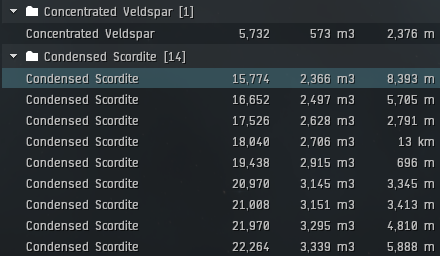

In [5]:
full_screen_image.crop(survey_scan_results_box)

In [6]:
import decimal

def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)
        
def cell_dims(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

def cell_dims_from_list(list_onbj):
    return cell_dims(list_onbj[0], list_onbj[1], list_onbj[2], list_onbj[3])

In [7]:
space = (survey_scan_results_box[3] - survey_scan_results_box[1]) / 12
row_points= list(drange(survey_scan_results_box[1], survey_scan_results_box[3], f'{space}'))
final_row_points = list(np.rint(np.asarray(row_points)).astype(int))
final_row_points

[1076, 1097, 1119, 1140, 1161, 1183, 1204, 1225, 1247, 1268, 1289, 1311, 1332]

In [8]:
col_delta = survey_scan_results_box[2] - survey_scan_results_box[0]
cols_points =  [col_delta * .05, col_delta * .45, col_delta * .15, col_delta * .18]

temp_list = []

for i in range(len(cols_points)):
    this_int = survey_scan_results_box[0]
    for j in range(i + 1):
        this_int += cols_points[j]
    temp_list.append(this_int)

final_col_points = np.array(temp_list)

final_col_points = list(np.rint(final_col_points).astype(int))
final_col_points = [survey_scan_results_box[0]] + final_col_points + [survey_scan_results_box[2]]
final_col_points

[1610, 1632, 1830, 1896, 1975, 2050]

In [9]:
x_range = final_col_points
y_range = final_row_points

cells = {}

for i, x in enumerate(x_range):
    for j, y in enumerate(y_range):
        try:
            cells[i, j] = tuple([x, y, x + x_range[i+1], y + y_range[j+1]])
        except:
            pass

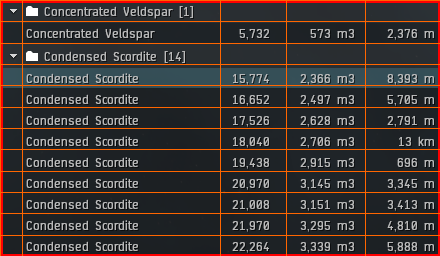

In [10]:
full_screen_image_copy = full_screen_image.copy()
img1 = ImageDraw.Draw(full_screen_image_copy)  

# box
img1.line([survey_scan_results_box[0], survey_scan_results_box[1], survey_scan_results_box[0], survey_scan_results_box[3]], fill ="red", width = 5)
img1.line([survey_scan_results_box[0], survey_scan_results_box[3], survey_scan_results_box[2], survey_scan_results_box[3]], fill ="red", width = 5)
img1.line([survey_scan_results_box[2], survey_scan_results_box[3],survey_scan_results_box[2], survey_scan_results_box[1]], fill ="red", width = 5)
img1.line([survey_scan_results_box[2], survey_scan_results_box[1],survey_scan_results_box[0], survey_scan_results_box[1]], fill ="red", width = 5)
# rows
for i in final_row_points:
    img1.line([survey_scan_results_box[0], i, survey_scan_results_box[2], i], fill="#ff6600", width=1)
# cols
for i in final_col_points:
    img1.line([i, survey_scan_results_box[1], i, survey_scan_results_box[3]], fill="#ff6600", width=1)


full_screen_image_copy.crop(survey_scan_results_box)

In [11]:
from pytesseract import pytesseract
import pandas as pd
from tqdm import tqdm

# Models
https://github.com/tesseract-ocr/tessdata_best/blob/main/eng.traineddata  
C:\Program Files\Tesseract-OCR\tessdata

In [12]:
frames = []
columns = ['Locked', 'Ore', 'Quantity', 'Volume', 'Distance', 'click_target']
for i in tqdm(range(12)):
    frame = {}
    for j in range(0, 5):
        cell = cell_dims_from_list(list(cells[j, i]))
        cell_image = full_screen_image.crop(cell)

        transcript = pytesseract.image_to_string(cell_image, lang='eng')
        
        frame[columns[j]] = transcript.replace('\n','').replace('+','').replace('>','').replace('k m', ' km')
    frame['click_target'] = (cells[1, i][0] + 10, cells[1, i][1] + 10) # offset by 10x10 pixels
    frames.append(frame)
df = pd.DataFrame(frames, columns=columns)
df.loc[df['Locked'] != '', 'Locked'] = '><'
df

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:07<00:00,  1.57it/s]


,Locked,Ore,Quantity,Volume,Distance,click_target
0,,Mm Concentrated Veldspar [1],,,,"(1642, 1086)"
1,,Concentrated Veldspar,5732,573 m3,2376 m,"(1642, 1107)"
2,,Condensed Scordite [14],,,,"(1642, 1129)"
3,,Condensed Scordite,15774,2366 m3,8333 m,"(1642, 1150)"
4,,Condensed Scordite,"16,652",2497 m3,5705 m,"(1642, 1171)"
5,,Condensed Scordite,17526,2.628 m3,2781 m,"(1642, 1193)"
6,,Condensed Scordite,"18,040",2.786 m3,13 km,"(1642, 1214)"
7,,Condensed Scordite,"19,438",2915 m3,696 m,"(1642, 1235)"
8,,Condensed Scordite,"28,970","3,145 m3",3345 m,"(1642, 1257)"
9,><,Condensed Scordite,"21,008","3,151 m3",3413 m,"(1642, 1278)"


In [13]:
indicies = df[df['Quantity'].str.len()>0][0:2].index

In [14]:
df[df['Quantity'].str.len()>0][0:2]

,Locked,Ore,Quantity,Volume,Distance,click_target
1,,Concentrated Veldspar,5732,573 m3,2376 m,"(1642, 1107)"
3,,Condensed Scordite,15774,2366 m3,8333 m,"(1642, 1150)"


In [15]:
df.loc[indicies[0], 'click_target']

(1642, 1107)

In [16]:
import time

In [ ]:
time.sleep(0.5)

indicies = df[df['Quantity'].str.len()>0][0:2].index

for i in indicies:
    pyautogui.moveTo(df.loc[i, 'click_target'])
    time.sleep(0.1)
    pyautogui.keyDown('ctrl')
    time.sleep(0.1)
    pyautogui.click()
    time.sleep(0.1)
    pyautogui.keyUp('ctrl')
    time.sleep(0.5)
time.sleep(3)
for i, index in enumerate(indicies):
    pyautogui.moveTo(df.loc[index, 'click_target'])
    time.sleep(0.1)
    pyautogui.click()
    time.sleep(0.1)
    pyautogui.press(f'f{i + 1}')
    time.sleep(0.5)